In [ ]:
# !pip show tensorflow

In [ ]:
# !pip show pymc

In [ ]:
# This file applies bayesian bernuolli regression to the [1995] wisconsin breast cancer dataset.
# The 1995 dataset is based on the original [1992] dataset,
# for which the 1995 dataset has been cleaned and missing values have been imputed

In [1]:
import numpy as np
import pymc as pm
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the original dataset

# min had to be done in google collab for compatibility issues
# yours can be probably done locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/1992.csv')

In [4]:
# see whats missing
missing_values_count = dataset.isna().sum()
missing_values_count

id                              0
Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
diagnosis                       0
dtype: int64

In [5]:
# basic - impute with median
import pandas as pd
import numpy as np
from scipy.stats import skew

# Function to determine filling strategy
def filling_strategy(column):
    if pd.isna(column).sum() == 0:
        return column  # No NaNs in the column
    skewness = skew(column.dropna())
    zero_portion = (column == 0).sum() / len(column)

    if abs(skewness) < 0.5 and zero_portion < 0.1:  # Thresholds can be adjusted
        print("mean")
        return column.fillna(column.mean())
    elif zero_portion >= 0.1:
        print("constant")
        return column.fillna(0)
    else:
        print("median")
        return column.fillna(column.median())

In [6]:
# Apply the function to each column
dataset = dataset.apply(filling_strategy)

median


In [7]:
# Separate features and target variable

# use 'diagnosis' column as the labels
dataset.rename(columns={'diagnosis': 'label'}, inplace=True)
y = dataset['label']  # Target variable
y = y.map({2: 0, 4: 1})


In [8]:
y

0      0
1      0
2      0
3      0
4      0
      ..
694    0
695    0
696    1
697    1
698    1
Name: label, Length: 699, dtype: int64

In [9]:
# remove ID column from X
X = dataset
X.drop(['id'], axis=1, inplace=True)
X.drop(['label'], axis=1, inplace=True)

In [10]:
X.columns

Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses'],
      dtype='object')

In [11]:
# see whats missing
missing_values_count = dataset.isna().sum()
missing_values_count

Clump_thickness                0
Uniformity_of_cell_size        0
Uniformity_of_cell_shape       0
Marginal_adhesion              0
Single_epithelial_cell_size    0
Bare_nuclei                    0
Bland_chromatin                0
Normal_nucleoli                0
Mitoses                        0
dtype: int64

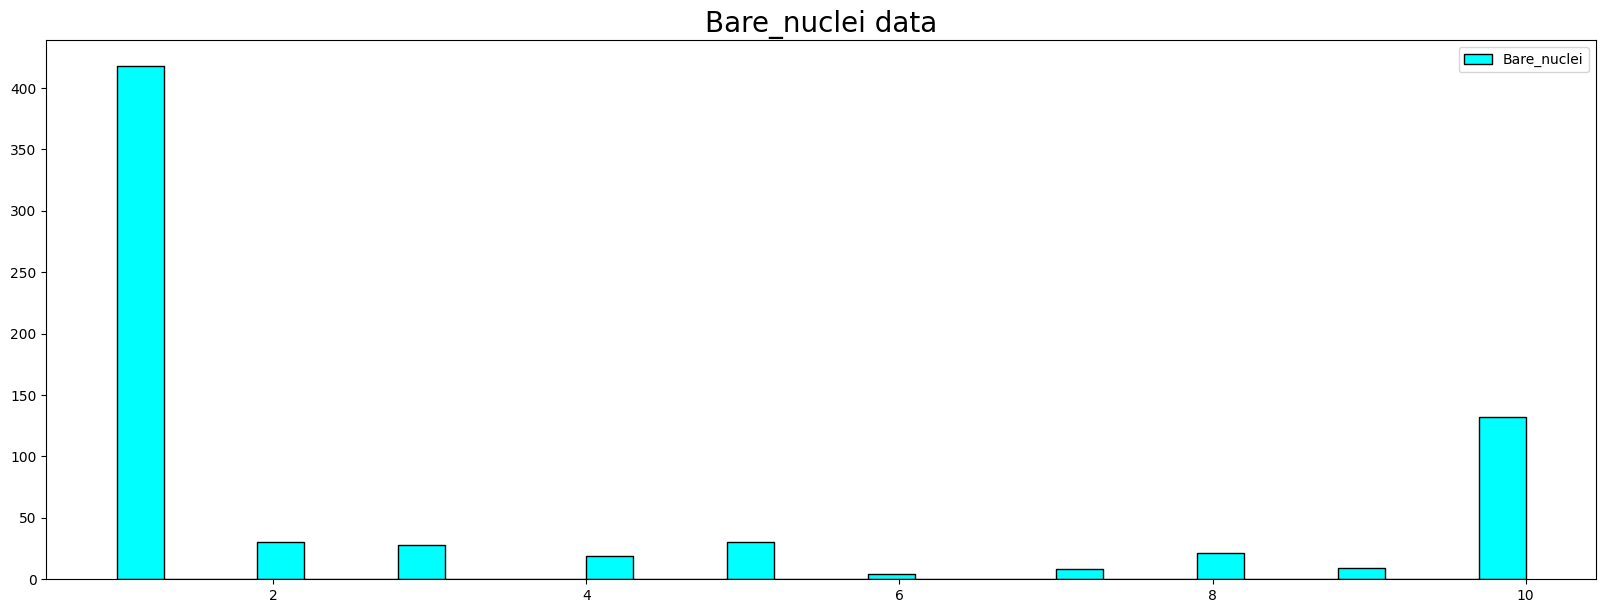

In [12]:
import random

import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.optimize

from matplotlib.lines import Line2D
from pymc.sampling.jax import sample_blackjax_nuts, sample_numpyro_nuts
from scipy.stats import multivariate_normal

fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(dataset["Bare_nuclei"], bins=30, ec="black", color="cyan", label="Bare_nuclei")
ax.set_title("Bare_nuclei data", fontsize=20)
ax.legend();

In [ ]:
# SO, the column which contains missing values (Bare Nuclei) is not normally distributed
# it is some U-shaped distribution. thoughts? beta? if beta, need to be in 0,1 excl boundary

In [13]:
X.columns

Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses'],
      dtype='object')

In [15]:
X['Bare_nuclei'].unique()

array([ 1., 10.,  2.,  4.,  3.,  9.,  7.,  5.,  8.,  6.])

In [16]:
# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
X_train

array([[ 0.20693572, -0.37204831, -0.74329904, ..., -0.17966213,
        -0.61182504, -0.34391178],
       [ 0.20693572, -0.04410156, -0.06984988, ..., -0.17966213,
         0.37131451, -0.34391178],
       [-1.2146669 , -0.69999505, -0.74329904, ..., -0.17966213,
        -0.61182504, -0.34391178],
       ...,
       [ 1.27313768,  0.28384518,  1.27704844, ..., -0.17966213,
         2.00988041,  0.23956962],
       [ 1.983939  ,  1.59563215,  2.28722218, ...,  0.64114721,
        -0.61182504, -0.34391178],
       [-0.14846494, -0.69999505, -0.40657446, ..., -0.17966213,
        -0.61182504, -0.34391178]])

In [19]:
num_features = X_train.shape[1]
num_features

9

In [20]:
# sample all points tbh.... dataset is so small.
num_samples = X_train.shape[0]
num_samples

559

In [21]:
#
# set up the model
#
bayesian_bernuolli_model = pm.Model()

with bayesian_bernuolli_model:

    # priors for theta and bias term
    b0 = pm.Normal("b0", mu=0, sigma=10) # bias term, normally distributed is fine
    thetas = pm.Normal("thetas", mu=0, sigma=10, shape=num_features) # dim thetas =30, normally distributed prior is fine

    # ultimately, p = sigmoid(a + thetaX)
    predictor = b0 + pm.math.dot(X_train, thetas) # can't be np object, use pm math

    # sigmoid function (transfer or response function)
    # maps thetaX to a probability [0,1]
    h_x = pm.math.sigmoid(predictor)

    # likelihood function for a binary outcome (Bernoulli distribution)
    # p = probability that Y=1
    likelihood = pm.Bernoulli('likelihood', p=h_x, observed=y_train)
    # likelihood = p(D|theta)

In [22]:
#
# perform MCMC sampling to draw from the posterior distribution of my params.
#  * for each theta, generate a distribution based on data and prior
#
with bayesian_bernuolli_model:

    # 'sample' traverses the graph and generate samples from the posterior distribution
    # trace = pm.sample(draws=num_samples, tune=1000)
    trace = pm.sample(draws=500, tune=1000)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-1.44,0.39,-2.25,-0.77,0.02,0.01,637.0,589.0,1.01
thetas[0],1.68,0.46,0.89,2.61,0.02,0.01,670.0,682.0,1.00
thetas[1],0.15,0.75,-1.12,1.53,0.03,0.02,541.0,527.0,1.00
thetas[2],1.27,0.79,-0.23,2.67,0.04,0.03,471.0,514.0,1.00
thetas[3],0.64,0.39,-0.07,1.31,0.01,0.01,738.0,851.0,1.00
thetas[4],0.28,0.37,-0.46,0.97,0.01,0.01,1031.0,672.0,1.00
thetas[5],1.78,0.40,1.02,2.52,0.01,0.01,852.0,566.0,1.00
thetas[6],1.02,0.41,0.25,1.77,0.01,0.01,811.0,560.0,1.00
thetas[7],0.01,0.40,-0.75,0.78,0.01,0.01,896.0,565.0,1.00
thetas[8],0.80,0.51,-0.17,1.69,0.02,0.01,855.0,662.0,1.00


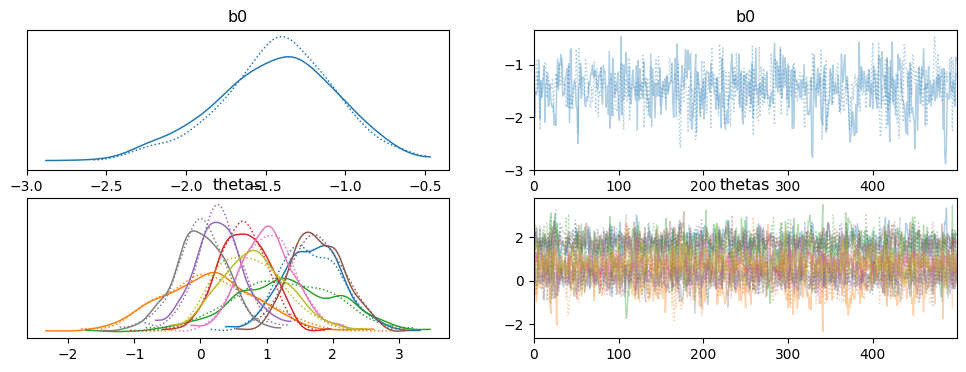

In [23]:
# ensure that there is convergence
pm.plot_trace(trace)
pm.summary(trace).round(2)

In [24]:
# need to take mean across all chains and draws
trace.posterior['thetas'].mean(dim=['chain', 'draw'])

<xarray.DataArray 'thetas' (thetas_dim_0: 9)>
array([1.68406934, 0.14858885, 1.27136152, 0.64216146, 0.28356934,
       1.77629435, 1.01802985, 0.01017179, 0.79584052])
Coordinates:
  * thetas_dim_0  (thetas_dim_0) int64 0 1 2 3 4 5 6 7 8

In [25]:
# Predictions

In [26]:
# now that we have our posterior, choose action based on the posterior
posterior_mean_thetas = trace.posterior['thetas'].mean(dim=['chain', 'draw'])
posterior_mean_bias = trace.posterior['b0'].mean(dim=['chain', 'draw']).item() #use item() to make it a scalar


In [27]:
posterior_mean_thetas.shape

(9,)

In [28]:
# posterior_mean_bias = trace.posterior['b0'].mean()
posterior_mean_bias
# trace.posterior['b0']

-1.44451697011685

In [29]:
# perform inference on the test set
test_predictions_hx = np.dot(X_test, posterior_mean_thetas) + posterior_mean_bias
test_predictions_hx

array([-7.06405538, -5.40694627, -5.58766141,  3.18713554, -5.58766141,
       -6.7847001 , -4.91728267,  6.33941906,  5.73409994, -1.39187146,
       -6.18618075,  0.93970758, -6.00546561, -4.60610356, -6.00546561,
        9.46976497, -7.62030851,  9.55306884,  4.00982354,  1.84678375,
       14.26534625, -7.33065876,  0.32860048, -7.62030851,  5.59520819,
       -3.92626457, -5.82475047,  7.51016354, -4.97247491,  4.83676305,
       -6.00213218, -5.37463773, -5.40694627,  5.03993166, -7.62030851,
       -4.80509349, -6.42326982, 14.44261808, -7.74846297,  7.20145891,
       -6.18618075, -3.93143767,  6.76226079, -7.20250431, -6.00546561,
       -4.80842692, -4.05998871, -1.22216479, -5.91820828, -3.5096795 ,
       -4.38952553, -6.7847001 ,  8.38064684, -6.91285456, -1.50843915,
       -5.1389738 , -4.80842692,  5.83472268, -6.42326982, -5.58766141,
       -6.18618075, -6.47446142,  7.08125505, -4.48591209, -6.91285456,
       -6.55142427,  7.7985625 ,  3.67231804, -3.89317693, -5.31

In [30]:
# then, need to fit this to the sigmoid transfer function?
test_probabilities = 1 / (1 + np.exp(-test_predictions_hx))
test_probabilities

array([8.54571558e-04, 4.46528806e-03, 3.72980924e-03, 9.60347285e-01,
       3.72980924e-03, 1.12966923e-03, 7.26581354e-03, 9.98237783e-01,
       9.96776632e-01, 1.99109157e-01, 2.05344520e-03, 7.19040586e-01,
       2.45917877e-03, 9.89184450e-03, 2.45917877e-03, 9.99922856e-01,
       4.90150152e-04, 9.99929022e-01, 9.82186481e-01, 8.63749036e-01,
       9.99999362e-01, 6.54712932e-04, 5.81418813e-01, 4.90150152e-04,
       9.96298129e-01, 1.93359370e-02, 2.94484334e-03, 9.99452808e-01,
       6.87834628e-03, 9.92129742e-01, 2.46736968e-03, 4.61123471e-03,
       4.46528806e-03, 9.93567455e-01, 4.90150152e-04, 8.12143769e-03,
       1.62070856e-03, 9.99999466e-01, 4.31219084e-04, 9.99255058e-01,
       2.05344520e-03, 1.92380879e-02, 9.98844725e-01, 7.44164276e-04,
       2.45917877e-03, 8.09462930e-03, 1.69567237e-02, 2.27555712e-01,
       2.68279883e-03, 2.90380710e-02, 1.22545766e-02, 1.12966923e-03,
       9.99770791e-01, 9.93924831e-04, 1.81170226e-01, 5.82952139e-03,
      

In [31]:
# tunable additional parameter, for classification it can be just > .5
threshold = 0.5

predicted_labels = (test_probabilities >= threshold).astype(int)
predicted_labels

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0])

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [33]:
# Assuming y_test contains the true labels

# Accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_test, predicted_labels)
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_test, predicted_labels)
print(f'Recall: {recall}')

# F1 Score
f1 = f1_score(y_test, predicted_labels)
print(f'F1 Score: {f1}')

# ROC-AUC Score (if you have probabilities)
roc_auc = roc_auc_score(y_test, test_predictions_hx)  # Use probabilities, not labels
print(f'ROC-AUC Score: {roc_auc}')

Accuracy: 0.9642857142857143
Precision: 0.9761904761904762
Recall: 0.9111111111111111
F1 Score: 0.9425287356321839
ROC-AUC Score: 0.9967251461988305


In [34]:
# Confusion matrix
print(confusion_matrix(y_test, predicted_labels))

# Classification report
print(classification_report(y_test, predicted_labels))

# Accuracy score
print("Accuracy:", accuracy_score(y_test, predicted_labels))

# ROC-AUC score (uses probabbilities)
roc_auc = roc_auc_score(y_test, test_predictions_hx)  # use probabilities, not labels
print("ROC-AUC Score:", roc_auc)

[[94  1]
 [ 4 41]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        95
           1       0.98      0.91      0.94        45

    accuracy                           0.96       140
   macro avg       0.97      0.95      0.96       140
weighted avg       0.96      0.96      0.96       140

Accuracy: 0.9642857142857143
ROC-AUC Score: 0.9967251461988305
